<a href="https://colab.research.google.com/github/aniketsharma00411/sign-language-to-text-translator/blob/main/mobilenet_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import files
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.applications.mobilenet import MobileNet
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists(os.path.expanduser('~')+'/.kaggle'):
    ! mkdir ~/.kaggle
os.chdir(os.path.expanduser('~')+'/.kaggle')
if not os.path.exists(os.path.expanduser('~')+'/.kaggle/kaggle.json'):
    kaggle_api_file = files.upload()
    ! kaggle datasets download -d grassknoted/asl-alphabet
    ! unzip -q asl-alphabet.zip
    ! rm -rf asl_alphabet_train/asl_alphabet_train/del

Saving kaggle.json to kaggle.json
 98% 1.01G/1.03G [00:07<00:00, 148MB/s]
100% 1.03G/1.03G [00:07<00:00, 139MB/s]


In [ ]:
! ls

asl_alphabet_test  asl_alphabet_train  asl-alphabet.zip  kaggle.json


# Data preprocessing

In [ ]:
train_data = 'asl_alphabet_train/asl_alphabet_train'

In [ ]:
image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.2, 1),
    shear_range=45,
    zoom_range=(0.5, 1.5),
    fill_mode='reflect',
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2
    )

In [ ]:
train_gen = image_gen.flow_from_directory(
    train_data,
    target_size=(224,224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    seed=0,
    subset='training'
    )

Found 67200 images belonging to 28 classes.


In [ ]:
val_gen = image_gen.flow_from_directory(
    train_data,
    target_size=(224,224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32,
    seed=0,
    subset='validation'
    )

Found 16800 images belonging to 28 classes.


In [ ]:
train_gen.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'nothing': 26,
 'space': 27}

# Creating model

In [ ]:
base_model = MobileNet(include_top=False,
                       weights='imagenet',
                       input_shape=(224,224,3),
                       pooling='avg')

end_model = models.Sequential()
end_model.add(layers.Flatten(input_shape=base_model.output_shape[1:]))
end_model.add(layers.Dense(64))
end_model.add(layers.LeakyReLU())
end_model.add(layers.Dense(64))
end_model.add(layers.LeakyReLU())
end_model.add(layers.Dense(28, activation='softmax'))

model = models.Model(inputs=base_model.input, outputs=end_model(base_model.output))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=5,
                                        mode='min',
                                        restore_best_weights=True)

# Training the model

In [ ]:
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[early_stopping_callback]
    )

Epoch 1/25
2100/2100 [==============================] - 1097s 499ms/step - loss: 1.4821 - accuracy: 0.5576 - val_loss: 1.1404 - val_accuracy: 0.6555
Epoch 2/25
2100/2100 [==============================] - 1037s 494ms/step - loss: 0.6475 - accuracy: 0.7942 - val_loss: 1.0670 - val_accuracy: 0.6804
Epoch 3/25
2100/2100 [==============================] - 1027s 489ms/step - loss: 0.5539 - accuracy: 0.8213 - val_loss: 1.0167 - val_accuracy: 0.6976
Epoch 4/25
2100/2100 [==============================] - 1055s 502ms/step - loss: 0.5246 - accuracy: 0.8312 - val_loss: 1.0492 - val_accuracy: 0.6932
Epoch 5/25
2100/2100 [==============================] - 1064s 507ms/step - loss: 0.4833 - accuracy: 0.8448 - val_loss: 1.0211 - val_accuracy: 0.6976
Epoch 6/25
2100/2100 [==============================] - 1039s 495ms/step - loss: 0.4625 - accuracy: 0.8489 - val_loss: 0.9666 - val_accuracy: 0.7168
Epoch 7/25
2100/2100 [==============================] - 1033s 492ms/step - loss: 0.4473 - accuracy: 0.8560

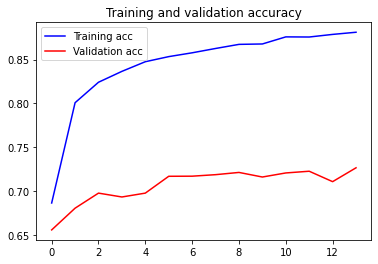

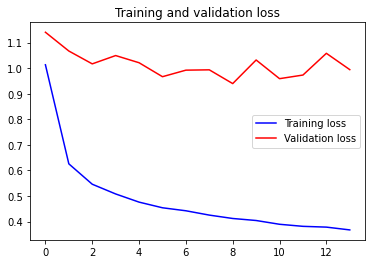

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Saving Model

In [ ]:
model.save('../asl_mobilenet_data_augmentation.h5')